<a href="https://colab.research.google.com/github/saigerutherford/fetal-code/blob/master/fetal_mask_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saige Rutherford 

email - saruther@med.umich.edu

>Research Computer Specialist

>Department of Psychiatry, University of Michigan

[Website/Blog](https://www.beingsaige.com)

[Twitter](https://www.twitter.com/being_saige)

[Fetal Code on GitHub](https://github.com/saigerutherford/fetal-code/)

New to python? When running this code on your own computer, I suggest using Anaconda to manage your python environment.
https://www.anaconda.com/distribution/

In [0]:
# Download text file that contains the required python packages needed to run this code 
# (if you look at the github there are different requirement.txt files for different platforms (Mac/Linux/Google Collab))
!wget -nc https://raw.githubusercontent.com/saigerutherford/fetal-code/master/Collab_Requirements.txt

--2019-10-16 18:01:57--  https://raw.githubusercontent.com/saigerutherford/fetal-code/master/Collab_Requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 513 [text/plain]
Saving to: ‘Collab_Requirements.txt’

Collab_Requirements 100%[===================>]     513  --.-KB/s    in 0s      

2019-10-16 18:01:57 (78.7 MB/s) - ‘Collab_Requirements.txt’ saved [513/513]



In [0]:
# Install the required python packages for running in Google Collab environment
# Note: there are different requirements.txt for Mac, Linux (checkout the github)
!pip install -r Collab_Requirements.txt

     |████████████████████████████████| 102kB 3.3MB/s 
     |████████████████████████████████| 194kB 11.8MB/s 
     |████████████████████████████████| 829kB 43.1MB/s 
     |████████████████████████████████| 2.8MB 31.2MB/s 
     |████████████████████████████████| 133kB 46.9MB/s 
     |████████████████████████████████| 13.1MB 30.8MB/s 
     |████████████████████████████████| 153kB 37.6MB/s 
     |████████████████████████████████| 3.3MB 27.2MB/s 
     |████████████████████████████████| 2.4MB 25.3MB/s 
     |████████████████████████████████| 3.3MB 26.0MB/s 
     |████████████████████████████████| 9.0MB 33.0MB/s 
     |████████████████████████████████| 17.3MB 32.1MB/s 
     |████████████████████████████████| 6.7MB 25.9MB/s 
     |████████████████████████████████| 25.2MB 1.8MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
     |████████████████████████████████| 31.4MB 29.3MB/s 
     |████████████████████████████████| 368kB 39.7MB/s 
     |████████████████████████████████| 51kB 2

In [0]:
# Add google drive folder so we can access the saved model and fetal test set
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# general python packages
from __future__ import print_function
import os 
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt

# neuroimaging-specific python packages
import nilearn
from nilearn import plotting
import nibabel as nib

# Step 0: Load The Data

## Thank you to Dustin Scheinost for sharing sample fetal fMRI data to test this code on.

## **\#openscience**

In [0]:
root_path = 'drive/My Drive/ISDP_Tutorial/'

In [0]:
sub1 = nib.load(root_path + 'data/zpr_FS0002_S014_vol0100.nii.gz')
sub2 = nib.load(root_path + 'data/zpr_FS0025_S008_vol0100.nii.gz')

## Step 1: Explore the raw data

In [0]:
%matplotlib inline

In [0]:
from nilearn.plotting import plot_epi, show

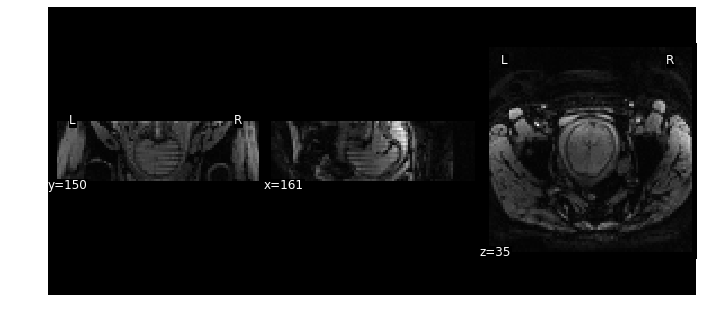

In [0]:
sub1_fig = plt.figure(figsize=(9, 4))
plot_epi(sub1, cmap='gray', draw_cross=False, figure=sub1_fig, cut_coords=[161, 150, 35])

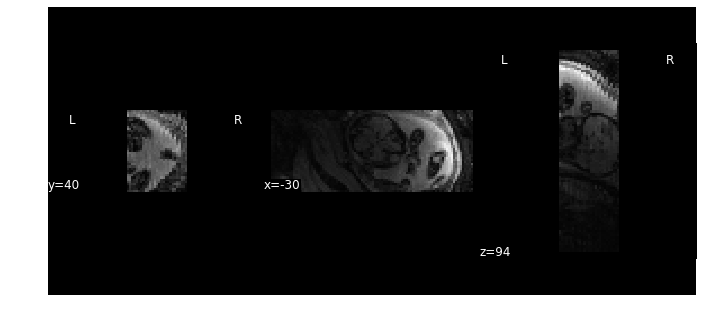

In [0]:
sub2_fig = plt.figure(figsize=(9, 4))
plot_epi(sub2, cmap='gray', draw_cross=False, figure=sub2_fig, cut_coords=[-30,40,94])

If we want to be able to scroll through the 3D image (without having to change the cut_coords variable) we can use BioImageSuite web, a super cool javascript tool created by Xenophon Papademetris and Dustin Scheinost.

[Link to Overlay Viewer](https://bioimagesuiteweb.github.io/webapp/viewer.html)

[Link to documentation](https://bioimagesuiteweb.github.io/webapp/images/IntroToBioImageSuiteWeb.pdf)

[Link to youtube channel tutorials](https://www.youtube.com/channel/UCizfR_ryJ0E-2uZspjwYtwg)

# Step 2: Check that the data is ready for the CNN model

## The auto mask model requires the data to be:
1. already split into 3D volumes (not in 4D)...I did this step beforehand using: 
`fslmaths 4D_subject.nii.gz subject_vol -t` 
2. image dimensions 96 x 96 x 37 (voxel size doesn't matter, but original training data was 3.5mm isotropic voxels)

In [0]:
sub1.shape

(96, 96, 37)

In [0]:
sub2.shape

(96, 37, 96)

# Step 3: Run the pre-trained auto-mask model
We will use a saved model that was trained on fetal data (177 subjects/1,066 volumes) collected at in Detroit, MI at Wayne State University.

Need to either:

a) run createMasks.py script from within code/ folder **OR** 

b) change the path in createMasks.py to find the saved models

Either way, when running this on your own, make sure to edit the createMasks.py script to match the correct paths to your images & that change the paths if you made any changes to the repo directory structure.


In [0]:
cd drive/My Drive/ISDP_Tutorial/code/

/content/drive/My Drive/ISDP_Tutorial/code


In [0]:
!python createMasks.py

2019-10-16 18:06:40.158412: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2019-10-16 18:06:40.158469: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2019-10-16 18:06:40.158483: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2019-10-16 18:06:40.158493: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2019-10-16 18:06:40.158503: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

# Step 4: Quality check the masks
## This is a super important step!

## Every masked volume needs to be inspected...

## There may need to be edits made to the masks before extracting the data. 

In [0]:
mask1 = '../data/3Dvolumes/pred_zpr_FS0002_S014_vol0016.nii.gz'
background1 = '../data/3Dvolumes/zpr_FS0002_S014_vol0016.nii.gz'

<Figure size 648x288 with 0 Axes>

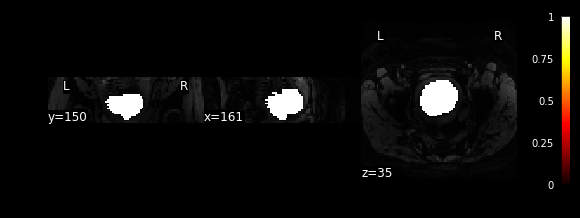

In [0]:
plt.figure(figsize=(9, 4))
plotting.plot_stat_map(mask1, bg_img=background1, draw_cross=False, cut_coords=[161, 150, 35])

## Again, let's use BioImageSuite to easily scroll through 3D space and adjust the mask overlay transparancy to check how well the mask aligns with the brain. 

[Link to Overlay Viewer](https://bioimagesuiteweb.github.io/webapp/viewer.html)


In [0]:
cd ../data/

/content/drive/My Drive/ISDP_Tutorial/data


# Step 5: Threshold/binarize, extract
## Masks are output as a probability image where 1 = brain & 0 = non-brain.

## First we threhold the masks to include only voxels with high probability of being brain (=1)

## Next we multiply the input image by the binary mask.

In [0]:
from nilearn.image import threshold_img
threshold_value_img = threshold_img('3Dvolumes/pred_zpr_FS0002_S014_vol0016.nii.gz', threshold=1.0)

In [0]:
from nilearn.image import math_img
result_img = math_img("img1 * img2", img1=threshold_value_img, img2='3Dvolumes/zpr_FS0002_S014_vol0016.nii.gz')

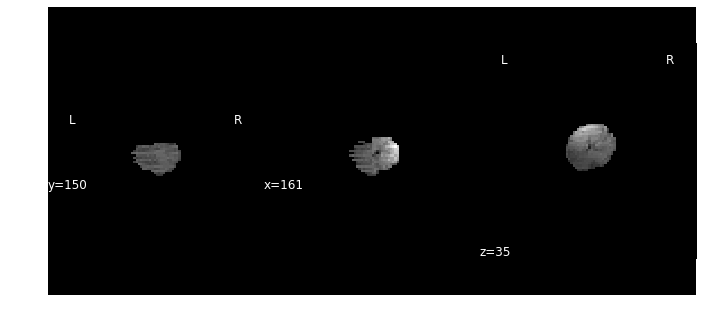

In [0]:
extract_fig = plt.figure(figsize=(9, 4))
plot_epi(result_img, cmap='gray', draw_cross=False, figure=extract_fig, cut_coords=[161, 150, 35])

In [0]:
# Save the extracted image back to a nifti file
nib.save(result_img, 'testextract.nii.gz')

[Link to Overlay Viewer](https://bioimagesuiteweb.github.io/webapp/viewer.html)

# Step 6 Motion...

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
ls

3Dvolumes/
Collab_Requirements.txt
e_zpr_4D_FS0002_S014.nii.gz
e_zpr_4D_FS0003_S009.nii.gz
e_zpr_4D_FS0004_S005.nii.gz
e_zpr_4D_FS0005_S017.nii.gz
fetal_motion_summary_allthresholds.csv
mask_zpr_4D_FS0002_S014.nii.gz
mask_zpr_4D_FS0003_S009.nii.gz
mask_zpr_4D_FS0004_S005.nii.gz
mask_zpr_4D_FS0005_S017.nii.gz
re_zpr_4D_FS0002_S014.mat/
re_zpr_4D_FS0002_S014.nii.gz
re_zpr_4D_FS0002_S014.nii.gz_meanvol.nii.gz
re_zpr_4D_FS0002_S014.par
re_zpr_4D_FS0002_S014_sigma.nii.gz
re_zpr_4D_FS0002_S014_variance.nii.gz
re_zpr_4D_FS0003_S009.mat/
re_zpr_4D_FS0003_S009_meanvol.nii.gz
re_zpr_4D_FS0003_S009.nii.gz
re_zpr_4D_FS0003_S009.par
re_zpr_4D_FS0003_S009_sigma.nii.gz
re_zpr_4D_FS0003_S009_variance.nii.gz
re_zpr_4D_FS0004_S005.mat/
re_zpr_4D_FS0004_S005_meanvol.nii.gz
re_zpr_4D_FS0004_S005.nii.gz
re_zpr_4D_FS0004_S005.par
re_zpr_4D_FS0004_S005_sigma.nii.gz
re_zpr_4D_FS0004_S005_variance.nii.gz
re_zpr_4D_FS0005_S017.mat/
re_zpr_4D_FS0005_S017_meanvol.nii.gz
re_zpr_4D_FS0005_S017.nii.gz
re_zpr_4D_FS00

In [0]:
all_motion = pd.read_csv('fetal_motion_summary_allthresholds.csv')

In [0]:
all_motion['Time (minutes)'].describe()

count    5392.000000
mean        4.980595
std         5.180448
min         0.033333
25%         0.700000
50%         3.333333
75%         7.666667
max        26.100000
Name: Time (minutes), dtype: float64

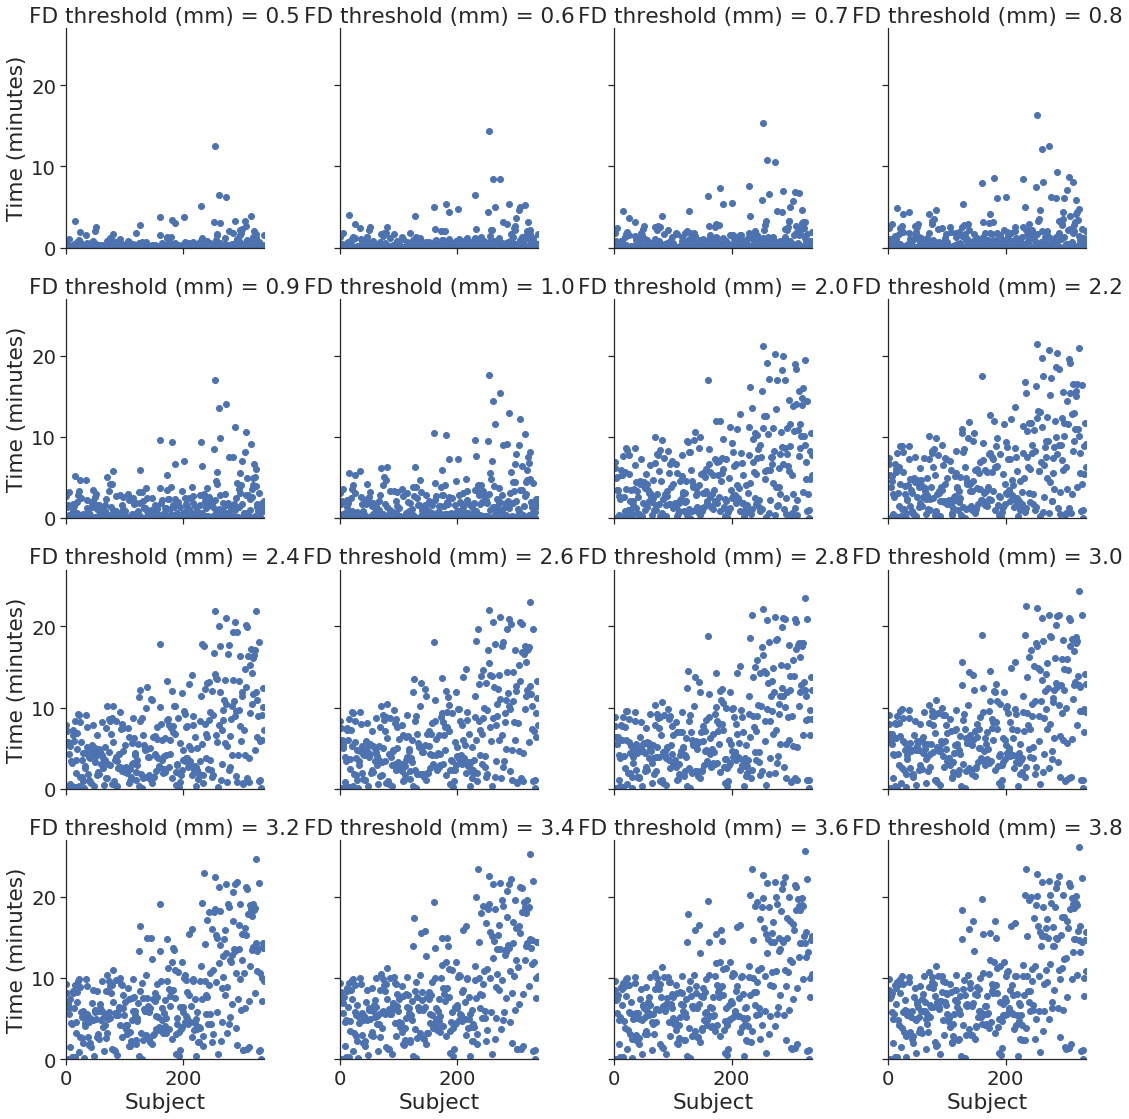

In [0]:
sns.set(style="ticks", font_scale=1.8)
#sns.set_context(font_scale=1.5)
grid = sns.FacetGrid(all_motion, col="FD threshold (mm)", col_wrap=4, height=4)
grid.map(plt.scatter, "Subject", "Time (minutes)", marker="o")
grid.set(xlim=(0, 337), ylim=(0, 27))